In [106]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as ds
from torchvision import models, transforms, utils, datasets
from torch.utils import data
from torchsummary import summary
from torch.optim import lr_scheduler

from PIL import Image



# Load in Is_Fish Classifier

In [54]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [55]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load("models/is_fish.pt"))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Idea for Workflow
- Use Fishbase as a test and validation set
- Build an initial proof of concept classifier for species that have enough data in FishBase

# Exploring Fishbase Dataset
### Determine Fishbase Test and Validation Sets"

In [38]:
fish_df = pd.read_csv("data/fish_df.csv")

In [28]:
sizes = {}
fishbase_source_path = "data/fishbase_images/"
for species_dir in os.listdir(fishbase_source_path):
    if species_dir == ".ipynb_checkpoints":
        continue
    image_count = len([name for name in os.listdir(fishbase_source_path + species_dir + "/") if name.split(".")[-1] != "gif"])
    #print(f"{species_dir}: {image_count}")
    sizes[species_dir] = image_count

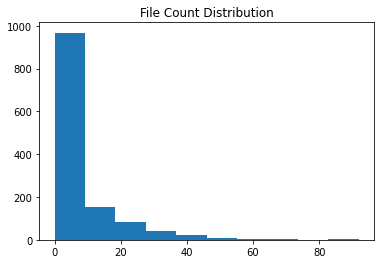

In [29]:
plt.hist(sizes.values())
plt.title("File Count Distribution")
plt.show()

In [39]:
# Find the number of species with a minimum count of images from fishbase
thresh = 25
mtt_species= []
for species, count in sizes.items():
    if count > thresh:
        mtt_species.append(species)
print(len(mtt_species))

99


### Find Scraped Image Counts for the Species that Meet IsFish Threshold 

In [80]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), ]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [83]:
# Method to parse a given directory and find the number of fish vs nonfish images
def count_fish(species_path):
    fish_count = 0
    not_fish_count = 0
    deltas = []
    image_paths = []
    for file in os.listdir(species_path):
        image_path = species_path + file
        try:
            img = Image.open(image_path).convert('RGB')
        except:
            continue
        img_filt = data_transforms(img).cuda().unsqueeze(0)
        outputs = model_ft(img_filt)

        _, preds =torch.max(outputs, 1)
        preds = preds.tolist()
        fish_score = outputs.tolist()[0][0]
        not_fish_score = outputs.tolist()[0][1]
        delta = fish_score - not_fish_score 
        preds = preds[0]
        # 1 is for not fish and 0 is for fish
        mod_pred = delta > -2

        if mod_pred == 1:
            fish_count += 1
            image_paths.append(image_path)

        else:
            not_fish_count += 1 
            deltas.append(delta)
            
    return fish_count, not_fish_count, image_paths
            

In [85]:
# Find scientific image count by species
sci_path = "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/scientific/" 
scientific_counts = dict()
for species_id in mtt_species:
    
    try:
        species_path = sci_path + species_id + "/"
        ic, _, _ = count_fish(species_path)
    except:
        ic = 0
    scientific_counts[species_id] = ic
    

In [90]:
# Find common image count by species
common_path = "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/regular/" 
common_counts = dict()
for species_id in mtt_species:
    try:
        species_path = common_path + species_id + "/"
        ic, _, _ = count_fish(species_path)
    except:
        ic = 0
    common_counts[species_id] = ic

In [97]:
# Find fish classes that have enough train data
all_thresh_ids = []
train_thresh = 50
for fid in mtt_species:
    if common_counts[fid] > train_thresh and scientific_counts[fid] > train_thresh:
        all_thresh_ids.append(fid)
print(len(all_thresh_ids))

92


# Generate Symlink Directories for Train, Test, Val
I am not sure how the model performance will change based on the training data, so I am trying to train it with three different training sets: once with scientific web scraped images, once with the common name web scraped images, and once with both combined. To do this however, I need to create training folder structures, which I do below via symlinks.

In [185]:
# Create directories needed for data
if not os.path.isdir("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_scientific/"):
    for subfolder in ["train/", "test/", "val/"]:
        for sid in all_thresh_ids:
            os.makedirs("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_scientific/" + subfolder + sid + "/")

if not os.path.isdir("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_common/"):
    for subfolder in ["train/", "test/", "val/"]:
        for sid in all_thresh_ids:
            os.makedirs("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_common/" + subfolder + sid + "/")



if not os.path.isdir("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/"):
    for subfolder in ["train/", "test/", "val/"]:
        for sid in all_thresh_ids:
            os.makedirs("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/" + subfolder + sid + "/")


In [186]:
source_data_path =  "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/"
fishbase_source_path = "/media/shivaram/SharedVolum/Projects/FishID/data/fishbase_images/"

save_dirs = ["/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_scientific/", "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_common/", "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/"]

random.seed(10)

count = 0
done = False 
for root_dir, cur_dir, files in os.walk("/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/"):
    if len(files) > 0:
        done = True

        
if not done:
    for species_id in all_thresh_ids:

        # Create validation and test sets from FishBase
        for file in os.listdir(fishbase_source_path + species_id + "/"):
            image_path = fishbase_source_path + species_id + "/" + file

            # Create test and validation datasets (same for each of the different datasets)
            test_val = bool(random.getrandbits(1))
            if test_val: 
                save_folder = "test/"
            else:
                save_folder = "val/" 
            for save_dir in save_dirs:
                save_path = save_dir + save_folder +  species_id + "/" + file 
                os.symlink(image_path, save_path)
                
        # Build scientific based dataset (and mixed)
        for file in os.listdir(source_data_path + "scientific/" + species_id + "/"):
            image_path  = source_data_path + "scientific/" + species_id + "/" + file

            savepath_sci = "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_scientific/train/" + species_id + "/" + file
            savepath_mixed = "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/train/" + species_id + "/" + file

            os.symlink(image_path, savepath_sci)
            os.symlink(image_path, savepath_mixed)


        # Build common name dataset (and mixed)
        skipped = 0
        fc = len(os.listdir(source_data_path + "regular/" + species_id + "/"))
        
        for file in os.listdir(source_data_path + "regular/" + species_id + "/"):
            image_path  = source_data_path + "regular/" + species_id + "/" + file

            savepath_common = "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_common/train/" + species_id + "/" + file
            savepath_mixed = "/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/train/" + species_id + "/" + file


            os.symlink(image_path, savepath_common)
            if os.path.exists(savepath_mixed):
                skipped += 1
            else:
                os.symlink(image_path, savepath_mixed)
                # DELETING PRIORS WHY?????

                
        print(f"Skipped {skipped}/{fc} for {species_id} because it was already ported from the scientific dataset")
    
    
    

Skipped 27/379 for 914 because it was already ported from the scientific dataset
Skipped 111/366 for 6024 because it was already ported from the scientific dataset
Skipped 7/500 for 6468 because it was already ported from the scientific dataset
Skipped 61/500 for 977 because it was already ported from the scientific dataset
Skipped 125/384 for 7293 because it was already ported from the scientific dataset
Skipped 118/426 for 6630 because it was already ported from the scientific dataset
Skipped 99/355 for 5598 because it was already ported from the scientific dataset
Skipped 76/497 for 2467 because it was already ported from the scientific dataset
Skipped 97/380 for 1260 because it was already ported from the scientific dataset
Skipped 17/347 for 3385 because it was already ported from the scientific dataset
Skipped 58/442 for 5950 because it was already ported from the scientific dataset
Skipped 53/363 for 1005 because it was already ported from the scientific dataset
Skipped 64/319 f

In [180]:
all_thresh_ids

['914',
 '6024',
 '6468',
 '977',
 '7293',
 '6630',
 '5598',
 '2467',
 '1260',
 '3385',
 '5950',
 '1005',
 '4274',
 '5584',
 '5952',
 '239',
 '1007',
 '3',
 '1309',
 '143',
 '753',
 '93',
 '4485',
 '2534',
 '1022',
 '1002',
 '4905',
 '1895',
 '6556',
 '1265',
 '4659',
 '4684',
 '998',
 '5791',
 '2576',
 '5557',
 '875',
 '868',
 '5444',
 '5824',
 '785',
 '1450',
 '5631',
 '10276',
 '6555',
 '89',
 '898',
 '874',
 '3231',
 '861',
 '1750',
 '387',
 '4278',
 '4914',
 '5606',
 '6401',
 '1258',
 '907',
 '5425',
 '107',
 '5562',
 '1261',
 '80',
 '5623',
 '5398',
 '5891',
 '5596',
 '988',
 '1869',
 '1732',
 '412',
 '271',
 '2081',
 '886',
 '226',
 '912',
 '6025',
 '1077',
 '6504',
 '917',
 '5553',
 '3276',
 '343',
 '6',
 '1235',
 '12600',
 '1906',
 '3228',
 '5923',
 '5645',
 '4275',
 '5839']

In [176]:
savepath_mixed

'/home/shivaram/DS/Projects/FishID/data/model_data/is_fish_mixed/train/5839/imagesqtbnand9gcs-extfg4rw9vkb7k0h5rgq36rp98utl7d8tqusqpcau.jpg'

In [177]:
im = Image.open(savepath_mixed)
im.show()